In [2]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#import awswrangler as wr
#import s3fs
#from fastparquet import write

import joblib

#modeling
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, f1_score, precision_recall_curve
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer, roc_auc_score, log_loss, brier_score_loss
from sklearn.utils import resample


#import lightgbm as lgbm

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install lightgbm --q
!pip install optuna --q

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.


### set-up

In [4]:
session = boto3.Session()
s3 = session.client('s3')

In [5]:
bucket_name = "cdo-ililapse-364524684987-bucket"
file_path = "x266754/lapse/"

### data intake

In [6]:
file_name = "x266754/lapse/curated_features.parquet"

In [7]:
%%time
obj = s3.get_object(Bucket = bucket_name, Key = file_name)
df = pd.read_parquet(io.BytesIO(obj['Body'].read())) 

CPU times: user 36.7 s, sys: 15.2 s, total: 51.9 s
Wall time: 42.2 s


In [8]:
macro = pd.read_csv("macro_fred.csv")

In [9]:
macro['macro_cur_month'] = macro['macro_date'].astype('datetime64[ns]').map(lambda x: x.strftime('%Y-%m'))

In [10]:
%%time
df=df.merge(macro, how='left', 
              left_on=['pfmc_cur_month'], 
              right_on = ['macro_cur_month'],
              suffixes=('', '_remove'))

CPU times: user 3min 31s, sys: 2min 13s, total: 5min 44s
Wall time: 5min 46s


### Metrics

In [11]:
#roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [12]:
def fn_importance_features(model):
    clf = model
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, clf.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

    # Plot the results
    pd.DataFrame(feature_importances_data)\
        .set_index('feature')\
        .sort_values(by='importance')[-15::]\
        .plot(title='Top 20 most important features: '+ str(type(model).__name__),
              kind='barh',figsize=(10, 6),
              color='#348ABD',alpha=0.6,
              lw='1', edgecolor='#348ABD',grid=False,)

In [13]:
#key performance metrics
def fn_metrics(act, prob, pred):
    #ROC
    fpr, tpr, thresholds = roc_curve(act, prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr)
    
    print ('ROC value of:{:.2f}'.format(roc_auc*100))
    print ('Accuracy:{:.2f}'.format(accuracy_score(act, pred)*100))
    print ('F1 score:{:.2f}'.format(f1_score(act, pred)*100))
    print ('Recall:{:.2f}'.format(recall_score(act, pred)*100))
    print ('Precision:{:.2f}'.format(precision_score(act, pred)*100))
    print ('\n clasification report:\n',classification_report(act, pred))
     
    #plot confusion matrix    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    plt.rcParams.update({'font.size': 16})
    ConfusionMatrixDisplay(confusion_matrix(pred, act, labels=[1,0]), 
                       display_labels=['3mo_ahead_lapse','No_Lapse']).plot(values_format=".0f",ax=ax)

    ax.set_xlabel("Actual Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

### Features

In [16]:
features =[
#target
'3mo_ahead_Lapse',
'pfmc_cur_month',

## CATEGORICAL:
'current_status',
'holder_age_bucket',

    
# pfmc    
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'place_abbrev',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
#'pension_code',
'pgls_product_code',
#'int_loan_typ_cd',
'abbr_pay_typ_cd',
'pln_id',
'prem_pattern_cd',
'ny_state_specific',
'rider_flag',

#household 
'incm_rng_cd', 
'prim_occup_cd',
'prmr_prsnc_chld_ind', 
'net_wrth_gold_cd',
'hhld_qdrnt_cd',    
    
#subject
'mrtl_stat_cd', 
'gndr_cd', 
'subj_state_cd', 
'subj_act_ind',               
'pref_lang_cd',
#'deceased_ind', 
'rtl_dstrb_orphn_cd',               
'ixi_buoyancy', 
'ixi_fin_cohort_cd',    
 
#clarify 
'SR_TYPE_CATG',

    
## NUMERICAL:

#pfmc
'policy_age',
'issue_year',
'mod_mpt_total',
'mod_mpt3',
'mod_mpt4',
'trgt_7_pay',
'mod_bld_payment',
'mod_sch_payment',
'base_face_amt',   
'cash_accum_prem',
'diff_mod_bld_value',
'mpt_total_bld_face_amt',
'accum_actual_prem_paid',
'mom_accum_prem_paid',
'prem_mode_change_flag',
'rest_mpt',
'diff_policy_issue_issue',
'diff_cash_holder_issue',
    
    
#household
'wc_tot_asset_amt',
'wc_asset_mix_anty_amt',
'wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt',
'wc_asset_mix_mf_amt',
'wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
'diff_household_asset_cash_val',
'hh_stock_mix',
'hh_bond_mix',
'hh_annuity_mix',
'num_policies_hh',
'mom_hh_policies',

    
#subject
'diff_aum_cash_val',

#clarify
'num_sr_catg',
'max_sr_time',
'time_to_close',
'num_sr_6m',

# macro
'Unemp',
'ICSA',
'Dincome',
'PCE',
'CPI',
'Leading',
'CS_HPI',
'SP500',
'ICE_Corp',
'ICE_HY',
'FF',
'T3M',
'T10Y2Y',
'Unemp_chg',
'ICSA_per',
'Dincome_per',
'PCE_per',
'CPI_per',
'Leading_per',
'CS_HPI_per',
'SP500_per',
'ICE_Corp_chg',
'ICE_HY_chg',
'FF_chg',
'T3M_chg',
'T10Y2Y_chg'
]

In [17]:
ml_dataset =df[features]
ml_dataset.shape

(4328736, 99)

### fill nan of categorical

In [18]:
# change None to NaN
ml_dataset.replace(to_replace=[None], value=np.nan, inplace=True)

In [19]:
cols = ['conv_type','premium_basis','tax_basis','incm_rng_cd', 'hhld_qdrnt_cd', 'mrtl_stat_cd', 
        'subj_act_ind', 'pref_lang_cd', 'rtl_dstrb_orphn_cd',
       'ixi_buoyancy', 'ixi_fin_cohort_cd']

ml_dataset[cols]= ml_dataset[cols].fillna(0)

### Categorical

In [20]:
%%time
cat_features = [
#'3mo_ahead_Lapse',
#'pfmc_cur_month',
'current_status',
'holder_age_bucket',

# pfmc    
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'place_abbrev',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
#'pension_code',
'pgls_product_code',
#'int_loan_typ_cd',
'abbr_pay_typ_cd',
'pln_id',
'prem_pattern_cd',
'ny_state_specific',
'rider_flag',

#household 
'incm_rng_cd', 
'prim_occup_cd',
'prmr_prsnc_chld_ind', 
'net_wrth_gold_cd',
'hhld_qdrnt_cd',    
    
#subject
'mrtl_stat_cd', 
'gndr_cd', 
'subj_state_cd', 
'subj_act_ind',               
'pref_lang_cd',
#'deceased_ind', 
'rtl_dstrb_orphn_cd',               
'ixi_buoyancy', 
'ixi_fin_cohort_cd',    
 
#clarify 
'SR_TYPE_CATG',
]   

for f in ml_dataset[cat_features]:
    print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(ml_dataset[f].values))
    ml_dataset[f] = lbl.transform(list(ml_dataset[f].values))

current_status
holder_age_bucket
prem_mode
val_inforce_cls
lob_group
prod_grp
place_abbrev
aos_status_code
smoking_habit
conv_type
premium_basis
tax_basis
div_option
spec_und_code
medical_issue_cd
pgls_product_code
abbr_pay_typ_cd
pln_id
prem_pattern_cd
ny_state_specific
rider_flag
incm_rng_cd
prim_occup_cd
prmr_prsnc_chld_ind
net_wrth_gold_cd
hhld_qdrnt_cd
mrtl_stat_cd
gndr_cd
subj_state_cd
subj_act_ind
pref_lang_cd
rtl_dstrb_orphn_cd
ixi_buoyancy
ixi_fin_cohort_cd
SR_TYPE_CATG
CPU times: user 1min 47s, sys: 23.2 s, total: 2min 10s
Wall time: 2min 10s


### Numerical

In [21]:
%%time
num_features = [

#pfmc
'policy_age',
'issue_year',
'mod_mpt_total',
'mod_mpt3',
'mod_mpt4',
'trgt_7_pay',
'mod_bld_payment',
'mod_sch_payment',
'base_face_amt',   
'cash_accum_prem',
'diff_mod_bld_value',
'mpt_total_bld_face_amt',
'accum_actual_prem_paid',
'mom_accum_prem_paid',
'prem_mode_change_flag',
'rest_mpt',
'diff_policy_issue_issue',
'diff_cash_holder_issue',
    
    
#household
'wc_tot_asset_amt',
'wc_asset_mix_anty_amt',
'wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt',
'wc_asset_mix_mf_amt',
'wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
'diff_household_asset_cash_val',
'hh_stock_mix',
'hh_bond_mix',
'hh_annuity_mix',
'num_policies_hh',
'mom_hh_policies',

    
#subject
'diff_aum_cash_val',

#clarify
'num_sr_catg',
'max_sr_time',
'time_to_close',
'num_sr_6m',

# macro 
'Unemp',
'ICSA',
'Dincome',
'PCE',
'CPI',
'Leading',
'CS_HPI',
'SP500',
'ICE_Corp',
'ICE_HY',
'FF',
'T3M',
'T10Y2Y',
'Unemp_chg',
'ICSA_per',
'Dincome_per',
'PCE_per',
'CPI_per',
'Leading_per',
'CS_HPI_per',
'SP500_per',
'ICE_Corp_chg',
'ICE_HY_chg',
'FF_chg',
'T3M_chg',
'T10Y2Y_chg'
]

for f in ml_dataset[num_features]:
    #print(f)
    _min = ml_dataset[f].min()
    _max = ml_dataset[f].max()
    scale = _max - _min
    shift = _min
    ml_dataset[f] = (ml_dataset[f] - shift).astype(np.float64) / scale

CPU times: user 4.92 s, sys: 6.08 s, total: 11 s
Wall time: 6.88 s


### Target, Split data

In [22]:
ml_dataset['__target__'] = ml_dataset['3mo_ahead_Lapse']
del ml_dataset['3mo_ahead_Lapse']

In [23]:
# train, valid, test
train, valid = train_test_split(ml_dataset, test_size=0.25, random_state=101)

valid, test = train_test_split(train, test_size=0.50, random_state=101)

train = train.drop(columns=['pfmc_cur_month'])
valid = valid.drop(columns=['pfmc_cur_month'])
test = test.drop(columns=['pfmc_cur_month'])

print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Valiation data has %i rows and %i columns' % (valid.shape[0], valid.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 3246552 rows and 98 columns
Valiation data has 1623276 rows and 98 columns
Test data has 1623276 rows and 98 columns


In [24]:
train_X = train.drop('__target__', axis=1)
valid_X = valid.drop('__target__', axis=1)
test_X = test.drop('__target__', axis=1)

train_Y = np.array(train['__target__'])
valid_Y = np.array(valid['__target__'])
test_Y = np.array(test['__target__'])

### LGBM Model

In [18]:
# !pip install lightgbm --q
# !pip install optuna --q

In [25]:
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
import optuna
from optuna.samplers import TPESampler
from optuna import Trial
from sklearn.model_selection import KFold

In [26]:
def accuracy(true, pred):
    return np.mean(true==pred)

def objective(trial):
    
    params = {
        'objective': 'binary', 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True), 
        'num_leaves': trial.suggest_int('num_leaves', 2, 300), 
        'max_depth': trial.suggest_int('max_depth', 1, 300), 
        'n_estimators': trial.suggest_int('n_estimators', 10, 300), 
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 1000), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 200.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 200.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.0, 1000.0),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0.0, 1.0),
        'random_state': 101
    }
    
    #scoring = { 'AUC': 'roc_auc',  'Log_loss': 'neg_log_loss', 'F1': 'f1','Recall': 'recall', 'Precision': 'precision'} 
    #score=[]
    clf = LGBMClassifier(**params)
    clf.fit(train_X, train_Y, eval_set = [(valid_X, valid_Y)], 
                              eval_metric =  'neg_log_loss',   #neg_log_loss, recall 
                              early_stopping_rounds = 50, verbose=50)
        
    #predicts
    pred = clf.predict(test_X)
    probs = clf.predict_proba(test_X)
    
    #metrics
    #acc = metrics.accuracy_score(pred, test_Y)
    recall = metrics.recall_score(pred, test_Y)
    precision = metrics.precision_score(pred, test_Y)
    f1 = metrics.f1_score(pred, test_Y)
    
#     pred = clf.predict(test_X)
#     true = test_Y
#     score.append(precision(true, pred))
#     score = np.mean(score)
    return f1, precision

### Optuna Tuning

In [27]:
study = optuna.create_study(directions=[ 'maximize', 'maximize'])
study.optimize(objective, n_trials=100)

[I 2022-12-22 19:08:18,044] A new study created in memory with name: no-name-65007c5e-36bf-4196-8708-a6c75f949796
[I 2022-12-22 19:08:39,896] Trial 0 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.004308151494622505, 'num_leaves': 158, 'max_depth': 28, 'n_estimators': 42, 'min_child_samples': 76, 'subsample': 0.7290766099813752, 'colsample_bytree': 0.7029510373624905, 'reg_alpha': 33.49501506190402, 'reg_lambda': 141.15504861498772, 'scale_pos_weight': 400.40273020420716, 'min_split_gain': 0.4877632617406291}. 
[I 2022-12-22 19:08:56,201] Trial 1 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0001534896670371243, 'num_leaves': 150, 'max_depth': 86, 'n_estimators': 15, 'min_child_samples': 597, 'subsample': 0.7033774550875354, 'colsample_bytree': 0.31451049758002614, 'reg_alpha': 117.46496101949508, 'reg_lambda': 143.41573269227158, 'scale_pos_weight': 433.9759350973488, 'min_split_gain': 0.2984582445852172}. 


[50]	valid_0's binary_logloss: 0.0328843


[I 2022-12-22 19:09:17,995] Trial 2 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.000734467400456749, 'num_leaves': 69, 'max_depth': 286, 'n_estimators': 134, 'min_child_samples': 378, 'subsample': 0.9067634494002167, 'colsample_bytree': 0.36760903872534617, 'reg_alpha': 80.71257819016147, 'reg_lambda': 81.76846297163283, 'scale_pos_weight': 671.5913752674312, 'min_split_gain': 0.7578751410990541}. 


[50]	valid_0's binary_logloss: 0.121687


[I 2022-12-22 19:09:45,118] Trial 3 finished with values: [0.1689984454807906, 0.1662661131745685] and parameters: {'learning_rate': 0.021976722901146512, 'num_leaves': 228, 'max_depth': 151, 'n_estimators': 195, 'min_child_samples': 361, 'subsample': 0.9326533348469404, 'colsample_bytree': 0.8990881827943769, 'reg_alpha': 32.16335798912071, 'reg_lambda': 97.20549761507655, 'scale_pos_weight': 116.58893858261321, 'min_split_gain': 0.09378016816755208}. 


[50]	valid_0's binary_logloss: 0.0713602


[I 2022-12-22 19:10:12,101] Trial 4 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00562453471237474, 'num_leaves': 285, 'max_depth': 185, 'n_estimators': 191, 'min_child_samples': 559, 'subsample': 0.7639369045912785, 'colsample_bytree': 0.41171929090212805, 'reg_alpha': 34.174285639000956, 'reg_lambda': 32.574825760095734, 'scale_pos_weight': 208.48541115449814, 'min_split_gain': 0.8831954409752947}. 
[I 2022-12-22 19:10:28,220] Trial 5 finished with values: [0.014136899645889916, 0.22460126720559317] and parameters: {'learning_rate': 0.07976644914176564, 'num_leaves': 74, 'max_depth': 221, 'n_estimators': 13, 'min_child_samples': 303, 'subsample': 0.8100898538448222, 'colsample_bytree': 0.7409094197862129, 'reg_alpha': 117.7133167993228, 'reg_lambda': 64.77832311584571, 'scale_pos_weight': 870.7811941900147, 'min_split_gain': 0.8788315262813289}. 


[50]	valid_0's binary_logloss: 0.0304526


[I 2022-12-22 19:10:54,632] Trial 6 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0009928954108636488, 'num_leaves': 247, 'max_depth': 186, 'n_estimators': 218, 'min_child_samples': 756, 'subsample': 0.8588382181256151, 'colsample_bytree': 0.764800934415276, 'reg_alpha': 95.08531366733818, 'reg_lambda': 7.728939716232297, 'scale_pos_weight': 458.4644451993204, 'min_split_gain': 0.5755053937326067}. 


[50]	valid_0's binary_logloss: 0.0274352


[I 2022-12-22 19:11:17,079] Trial 7 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0004520667455456043, 'num_leaves': 63, 'max_depth': 284, 'n_estimators': 86, 'min_child_samples': 184, 'subsample': 0.9114254637980101, 'colsample_bytree': 0.488623940211411, 'reg_alpha': 137.6509328815809, 'reg_lambda': 156.5907095747719, 'scale_pos_weight': 779.1516685505, 'min_split_gain': 0.12339004740284054}. 


[50]	valid_0's binary_logloss: 0.0383053


[I 2022-12-22 19:11:36,402] Trial 8 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0008546250173227438, 'num_leaves': 175, 'max_depth': 139, 'n_estimators': 202, 'min_child_samples': 295, 'subsample': 0.9762834527569594, 'colsample_bytree': 0.8551653168008106, 'reg_alpha': 105.41823869108154, 'reg_lambda': 111.46488512124641, 'scale_pos_weight': 923.7574678806583, 'min_split_gain': 0.4225377196053729}. 


[50]	valid_0's binary_logloss: 0.522402
[100]	valid_0's binary_logloss: 0.474064
[150]	valid_0's binary_logloss: 0.458927
[200]	valid_0's binary_logloss: 0.450782
[250]	valid_0's binary_logloss: 0.445078


[I 2022-12-22 19:12:32,115] Trial 9 finished with values: [0.031379598921365034, 0.5529823028184401] and parameters: {'learning_rate': 0.04321511988499542, 'num_leaves': 13, 'max_depth': 217, 'n_estimators': 293, 'min_child_samples': 449, 'subsample': 0.8034113139041839, 'colsample_bytree': 0.30650270547439284, 'reg_alpha': 43.79786659974882, 'reg_lambda': 117.28522608019765, 'scale_pos_weight': 310.11066906712415, 'min_split_gain': 0.35164496612179874}. 


[50]	valid_0's binary_logloss: 0.211355


[I 2022-12-22 19:12:55,859] Trial 10 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0070591975384708995, 'num_leaves': 57, 'max_depth': 227, 'n_estimators': 117, 'min_child_samples': 892, 'subsample': 0.8192766159146719, 'colsample_bytree': 0.4464948604842264, 'reg_alpha': 55.94770001661604, 'reg_lambda': 187.85495844647747, 'scale_pos_weight': 994.1740521390418, 'min_split_gain': 0.1994694761226773}. 


[50]	valid_0's binary_logloss: 0.0914818


[I 2022-12-22 19:13:15,646] Trial 11 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0030010520779902385, 'num_leaves': 294, 'max_depth': 230, 'n_estimators': 198, 'min_child_samples': 802, 'subsample': 0.7618446534898617, 'colsample_bytree': 0.6634380201579279, 'reg_alpha': 190.64699790032495, 'reg_lambda': 169.67366668107258, 'scale_pos_weight': 769.909273115423, 'min_split_gain': 0.8767113566997401}. 
[I 2022-12-22 19:13:39,267] Trial 12 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00010090567682729683, 'num_leaves': 274, 'max_depth': 278, 'n_estimators': 34, 'min_child_samples': 690, 'subsample': 0.9468662227101924, 'colsample_bytree': 0.7769656335811783, 'reg_alpha': 58.27999062445735, 'reg_lambda': 9.779749878475897, 'scale_pos_weight': 90.32165224327903, 'min_split_gain': 0.13873570559134207}. 


[50]	valid_0's binary_logloss: 0.975744


[I 2022-12-22 19:14:08,268] Trial 13 finished with values: [0.007350271527024462, 0.7231811230063361] and parameters: {'learning_rate': 0.06100211679907926, 'num_leaves': 251, 'max_depth': 144, 'n_estimators': 148, 'min_child_samples': 388, 'subsample': 0.8700671309937127, 'colsample_bytree': 0.6227919326537947, 'reg_alpha': 41.62061842266485, 'reg_lambda': 155.05944715062822, 'scale_pos_weight': 339.69641958806176, 'min_split_gain': 0.603249847041115}. 


[50]	valid_0's binary_logloss: 0.0249974


[I 2022-12-22 19:14:32,298] Trial 14 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00039255975393069414, 'num_leaves': 295, 'max_depth': 156, 'n_estimators': 233, 'min_child_samples': 196, 'subsample': 0.9753523311688719, 'colsample_bytree': 0.753103124053601, 'reg_alpha': 32.53276955465101, 'reg_lambda': 14.992341058013503, 'scale_pos_weight': 929.7804537721177, 'min_split_gain': 0.401267555308892}. 


[50]	valid_0's binary_logloss: 0.224211


[I 2022-12-22 19:14:58,991] Trial 15 finished with values: [0.04636037688651714, 0.24295389993445488] and parameters: {'learning_rate': 0.0199419091044948, 'num_leaves': 165, 'max_depth': 259, 'n_estimators': 278, 'min_child_samples': 831, 'subsample': 0.8360207083773059, 'colsample_bytree': 0.6472516416562913, 'reg_alpha': 1.8363564975875546, 'reg_lambda': 54.08976608277764, 'scale_pos_weight': 266.806554199829, 'min_split_gain': 0.5907753706044009}. 


[50]	valid_0's binary_logloss: 0.0514333


[I 2022-12-22 19:15:21,598] Trial 16 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0016970151386115188, 'num_leaves': 138, 'max_depth': 242, 'n_estimators': 189, 'min_child_samples': 972, 'subsample': 0.9523273255415193, 'colsample_bytree': 0.37940867699443376, 'reg_alpha': 199.8020772976664, 'reg_lambda': 67.75218572820714, 'scale_pos_weight': 545.5207714372201, 'min_split_gain': 0.26298045421334737}. 


[50]	valid_0's binary_logloss: 0.0732627


[I 2022-12-22 19:15:42,811] Trial 17 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00206132892967522, 'num_leaves': 15, 'max_depth': 138, 'n_estimators': 179, 'min_child_samples': 10, 'subsample': 0.7387647283412181, 'colsample_bytree': 0.34326738635596366, 'reg_alpha': 110.13919442261697, 'reg_lambda': 147.247849831234, 'scale_pos_weight': 911.6028012358373, 'min_split_gain': 0.3356443718607711}. 


[50]	valid_0's binary_logloss: 0.0213367


[I 2022-12-22 19:16:03,368] Trial 18 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00018003112877879087, 'num_leaves': 100, 'max_depth': 178, 'n_estimators': 74, 'min_child_samples': 791, 'subsample': 0.7935490848252069, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 34.720805304565936, 'reg_lambda': 184.08902546588166, 'scale_pos_weight': 690.9997077132914, 'min_split_gain': 0.9161099747491462}. 


[50]	valid_0's binary_logloss: 0.0199538


[I 2022-12-22 19:16:29,720] Trial 19 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00017069067056038265, 'num_leaves': 198, 'max_depth': 52, 'n_estimators': 298, 'min_child_samples': 859, 'subsample': 0.8370047653260452, 'colsample_bytree': 0.47594828529082867, 'reg_alpha': 176.06740128560006, 'reg_lambda': 50.90664745232007, 'scale_pos_weight': 323.4182030472199, 'min_split_gain': 0.33808849960890197}. 
[I 2022-12-22 19:16:50,273] Trial 20 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00038881419139765, 'num_leaves': 261, 'max_depth': 115, 'n_estimators': 44, 'min_child_samples': 689, 'subsample': 0.9318663029850309, 'colsample_bytree': 0.7687046410970257, 'reg_alpha': 68.4632585932621, 'reg_lambda': 63.92876631318678, 'scale_pos_weight': 367.62939621874636, 'min_split_gain': 0.36793090078722746}. 


[50]	valid_0's binary_logloss: 0.106398


[I 2022-12-22 19:17:17,887] Trial 21 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.004183441575434056, 'num_leaves': 274, 'max_depth': 262, 'n_estimators': 213, 'min_child_samples': 100, 'subsample': 0.7086928507534433, 'colsample_bytree': 0.514560778281095, 'reg_alpha': 132.99674671149992, 'reg_lambda': 7.211014168680174, 'scale_pos_weight': 840.0787202111334, 'min_split_gain': 0.5145450761767222}. 


[50]	valid_0's binary_logloss: 0.165628


[I 2022-12-22 19:17:41,268] Trial 22 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.006845217296896281, 'num_leaves': 206, 'max_depth': 57, 'n_estimators': 78, 'min_child_samples': 169, 'subsample': 0.9617010430390458, 'colsample_bytree': 0.7349518298395024, 'reg_alpha': 118.15512611769809, 'reg_lambda': 127.70195397309226, 'scale_pos_weight': 693.4601843951032, 'min_split_gain': 0.9451054414230883}. 


[50]	valid_0's binary_logloss: 10.4359


[I 2022-12-22 19:18:03,372] Trial 23 finished with values: [0.005847413289016096, 0.020755953681450733] and parameters: {'learning_rate': 0.0974224517624342, 'num_leaves': 73, 'max_depth': 163, 'n_estimators': 96, 'min_child_samples': 660, 'subsample': 0.7592607485456778, 'colsample_bytree': 0.7497998251342586, 'reg_alpha': 160.99682158179874, 'reg_lambda': 199.59410661558965, 'scale_pos_weight': 853.6263498945056, 'min_split_gain': 0.751238570040693}. 


[50]	valid_0's binary_logloss: 0.131651


[I 2022-12-22 19:18:27,606] Trial 24 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.004578765077452728, 'num_leaves': 55, 'max_depth': 181, 'n_estimators': 99, 'min_child_samples': 543, 'subsample': 0.7895497100511353, 'colsample_bytree': 0.546896166240209, 'reg_alpha': 118.71397746123216, 'reg_lambda': 131.35140572104933, 'scale_pos_weight': 806.2404845231778, 'min_split_gain': 0.7192432390831585}. 


[50]	valid_0's binary_logloss: 0.240955


[I 2022-12-22 19:18:55,417] Trial 25 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.015120626636433926, 'num_leaves': 162, 'max_depth': 171, 'n_estimators': 206, 'min_child_samples': 29, 'subsample': 0.8269085972905945, 'colsample_bytree': 0.5673344781966219, 'reg_alpha': 15.071279568919582, 'reg_lambda': 107.08030124138158, 'scale_pos_weight': 408.1189918049413, 'min_split_gain': 0.654291768897747}. 


[50]	valid_0's binary_logloss: 0.0427037


[I 2022-12-22 19:19:20,564] Trial 26 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.016049037997690564, 'num_leaves': 218, 'max_depth': 277, 'n_estimators': 81, 'min_child_samples': 403, 'subsample': 0.9848749228031652, 'colsample_bytree': 0.43873163635180235, 'reg_alpha': 65.1526791803888, 'reg_lambda': 153.24599001541554, 'scale_pos_weight': 31.33245213446212, 'min_split_gain': 0.7579896422389485}. 
[I 2022-12-22 19:19:35,719] Trial 27 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.003398233928531191, 'num_leaves': 267, 'max_depth': 200, 'n_estimators': 14, 'min_child_samples': 647, 'subsample': 0.9159150101918089, 'colsample_bytree': 0.9534432820464318, 'reg_alpha': 66.66144348867323, 'reg_lambda': 154.68024185499672, 'scale_pos_weight': 839.2061554555075, 'min_split_gain': 0.554292742153918}. 
[I 2022-12-22 19:19:52,480] Trial 28 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.006286496755043247, 'num_leaves': 29, 'ma

[50]	valid_0's binary_logloss: 0.251506


[I 2022-12-22 19:20:19,086] Trial 29 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.010260489024520024, 'num_leaves': 232, 'max_depth': 217, 'n_estimators': 232, 'min_child_samples': 528, 'subsample': 0.8227363905306386, 'colsample_bytree': 0.6197674604507923, 'reg_alpha': 90.73826813471335, 'reg_lambda': 73.68474417160414, 'scale_pos_weight': 934.7813592362766, 'min_split_gain': 0.4610738064711418}. 


[50]	valid_0's binary_logloss: 0.0317557


[I 2022-12-22 19:20:41,888] Trial 30 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0010047918126420662, 'num_leaves': 101, 'max_depth': 131, 'n_estimators': 160, 'min_child_samples': 760, 'subsample': 0.9906763412625871, 'colsample_bytree': 0.5772722199844681, 'reg_alpha': 182.27464199765896, 'reg_lambda': 81.32343671138204, 'scale_pos_weight': 354.9127859167134, 'min_split_gain': 0.04283438129459749}. 


[50]	valid_0's binary_logloss: 0.669383


[I 2022-12-22 19:21:07,672] Trial 31 finished with values: [0.01470408038230609, 0.6423421455101594] and parameters: {'learning_rate': 0.023883806784616712, 'num_leaves': 155, 'max_depth': 24, 'n_estimators': 112, 'min_child_samples': 764, 'subsample': 0.7434442823682571, 'colsample_bytree': 0.7162110467417605, 'reg_alpha': 164.51119106162636, 'reg_lambda': 4.077796330054029, 'scale_pos_weight': 888.4819726146029, 'min_split_gain': 0.24006907008854128}. 


[50]	valid_0's binary_logloss: 6.35441


[I 2022-12-22 19:21:37,115] Trial 32 finished with values: [0.004530001363398468, 0.11251911732575923] and parameters: {'learning_rate': 0.07145653838254044, 'num_leaves': 294, 'max_depth': 135, 'n_estimators': 155, 'min_child_samples': 172, 'subsample': 0.9208759285841974, 'colsample_bytree': 0.5365235623579206, 'reg_alpha': 193.3244103720163, 'reg_lambda': 178.9651992182949, 'scale_pos_weight': 930.9256324655473, 'min_split_gain': 0.3129481689218063}. 


[50]	valid_0's binary_logloss: 0.0888001


[I 2022-12-22 19:21:56,573] Trial 33 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0036221903735665162, 'num_leaves': 21, 'max_depth': 193, 'n_estimators': 294, 'min_child_samples': 32, 'subsample': 0.7706502776896512, 'colsample_bytree': 0.9977878795620163, 'reg_alpha': 126.29699287243668, 'reg_lambda': 146.77178467294763, 'scale_pos_weight': 501.5862873685331, 'min_split_gain': 0.33818483349911743}. 
[I 2022-12-22 19:22:13,684] Trial 34 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.007431764243671433, 'num_leaves': 94, 'max_depth': 27, 'n_estimators': 23, 'min_child_samples': 390, 'subsample': 0.7167822787445075, 'colsample_bytree': 0.8685123772596142, 'reg_alpha': 159.61617116484547, 'reg_lambda': 79.1918435359441, 'scale_pos_weight': 215.1497787329576, 'min_split_gain': 0.2624874666584931}. 


[50]	valid_0's binary_logloss: 0.191753


[I 2022-12-22 19:22:35,240] Trial 35 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.007955763538857593, 'num_leaves': 67, 'max_depth': 213, 'n_estimators': 173, 'min_child_samples': 594, 'subsample': 0.7340501315836534, 'colsample_bytree': 0.8381550217352427, 'reg_alpha': 53.416745465373424, 'reg_lambda': 168.6395225387875, 'scale_pos_weight': 668.5402704623092, 'min_split_gain': 0.3220433704064267}. 


[50]	valid_0's binary_logloss: 0.0659587


[I 2022-12-22 19:22:57,071] Trial 36 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.002577481917671423, 'num_leaves': 231, 'max_depth': 77, 'n_estimators': 260, 'min_child_samples': 826, 'subsample': 0.7191982780176378, 'colsample_bytree': 0.7956512642376843, 'reg_alpha': 144.4515996892658, 'reg_lambda': 52.017732610274535, 'scale_pos_weight': 521.1363208197973, 'min_split_gain': 0.45162510127784616}. 


[50]	valid_0's binary_logloss: 0.0230355


[I 2022-12-22 19:23:23,690] Trial 37 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00249521927032488, 'num_leaves': 121, 'max_depth': 243, 'n_estimators': 210, 'min_child_samples': 302, 'subsample': 0.8411489468357538, 'colsample_bytree': 0.5645432889848052, 'reg_alpha': 138.9548168663335, 'reg_lambda': 25.752905891490798, 'scale_pos_weight': 48.30800507101285, 'min_split_gain': 0.04039658352032138}. 


[50]	valid_0's binary_logloss: 0.0210555


[I 2022-12-22 19:23:43,196] Trial 38 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00016625274015280917, 'num_leaves': 56, 'max_depth': 246, 'n_estimators': 240, 'min_child_samples': 105, 'subsample': 0.7644099394848761, 'colsample_bytree': 0.8978525969829017, 'reg_alpha': 119.43307743625758, 'reg_lambda': 156.41804132379485, 'scale_pos_weight': 709.9761232652227, 'min_split_gain': 0.8897394393824064}. 


[50]	valid_0's binary_logloss: 0.0918769


[I 2022-12-22 19:24:07,644] Trial 39 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.012843376217675171, 'num_leaves': 291, 'max_depth': 181, 'n_estimators': 115, 'min_child_samples': 708, 'subsample': 0.981185065673528, 'colsample_bytree': 0.34897862385912104, 'reg_alpha': 131.02720322279254, 'reg_lambda': 136.33917163028576, 'scale_pos_weight': 109.01984818490318, 'min_split_gain': 0.6711351628612685}. 


[50]	valid_0's binary_logloss: 0.485755
[100]	valid_0's binary_logloss: 0.443189
[150]	valid_0's binary_logloss: 0.405392
[200]	valid_0's binary_logloss: 0.373704
[250]	valid_0's binary_logloss: 0.347261


[I 2022-12-22 19:25:26,541] Trial 40 finished with values: [0.07049819471463682, 0.9619838322045008] and parameters: {'learning_rate': 0.03256492148675404, 'num_leaves': 144, 'max_depth': 239, 'n_estimators': 262, 'min_child_samples': 506, 'subsample': 0.9122747422567423, 'colsample_bytree': 0.4749976238526813, 'reg_alpha': 13.506200061837026, 'reg_lambda': 43.64895297579028, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 0.0216695


[I 2022-12-22 19:25:48,544] Trial 41 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0003802485054819843, 'num_leaves': 53, 'max_depth': 10, 'n_estimators': 221, 'min_child_samples': 653, 'subsample': 0.7912904023517536, 'colsample_bytree': 0.8638953839752634, 'reg_alpha': 33.60957118906853, 'reg_lambda': 13.499360472764632, 'scale_pos_weight': 324.0305883447766, 'min_split_gain': 0.8393078721057287}. 
[I 2022-12-22 19:26:06,496] Trial 42 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0005203425740627183, 'num_leaves': 22, 'max_depth': 30, 'n_estimators': 40, 'min_child_samples': 346, 'subsample': 0.779457961993323, 'colsample_bytree': 0.7920900390804647, 'reg_alpha': 85.42702663544885, 'reg_lambda': 56.41134675416139, 'scale_pos_weight': 862.3170586835826, 'min_split_gain': 0.3977527513069913}. 


[50]	valid_0's binary_logloss: 0.741745
[100]	valid_0's binary_logloss: 0.554836
[150]	valid_0's binary_logloss: 0.467902


[I 2022-12-22 19:27:12,163] Trial 43 finished with values: [0.035876970842120944, 0.9997815162770374] and parameters: {'learning_rate': 0.047103377852706324, 'num_leaves': 209, 'max_depth': 239, 'n_estimators': 193, 'min_child_samples': 244, 'subsample': 0.711629475269932, 'colsample_bytree': 0.605603474727223, 'reg_alpha': 149.42857471341938, 'reg_lambda': 137.16775365614635, 'scale_pos_weight': 807.0082493837816, 'min_split_gain': 0.24335657433139601}. 


[50]	valid_0's binary_logloss: 0.725289
[100]	valid_0's binary_logloss: 0.558622
[150]	valid_0's binary_logloss: 0.485974
[200]	valid_0's binary_logloss: 0.433631
[250]	valid_0's binary_logloss: 0.390127


[I 2022-12-22 19:28:28,414] Trial 44 finished with values: [0.04800478473920024, 0.9995630325540747] and parameters: {'learning_rate': 0.045499004586588475, 'num_leaves': 165, 'max_depth': 260, 'n_estimators': 259, 'min_child_samples': 369, 'subsample': 0.998599604882513, 'colsample_bytree': 0.3978688331263057, 'reg_alpha': 35.57021540804084, 'reg_lambda': 175.24789410596046, 'scale_pos_weight': 636.9142177020569, 'min_split_gain': 0.6796487837469064}. 


[50]	valid_0's binary_logloss: 0.02157


[I 2022-12-22 19:28:49,735] Trial 45 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00023034596112217647, 'num_leaves': 227, 'max_depth': 146, 'n_estimators': 92, 'min_child_samples': 625, 'subsample': 0.7005625831056072, 'colsample_bytree': 0.313531551595858, 'reg_alpha': 115.43300825310277, 'reg_lambda': 148.96481225124364, 'scale_pos_weight': 465.61795943927655, 'min_split_gain': 0.9795914811323281}. 


[50]	valid_0's binary_logloss: 0.021814


[I 2022-12-22 19:29:10,159] Trial 46 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00020595059043108965, 'num_leaves': 90, 'max_depth': 122, 'n_estimators': 135, 'min_child_samples': 122, 'subsample': 0.9348587792360183, 'colsample_bytree': 0.6161413443092654, 'reg_alpha': 158.16919353086143, 'reg_lambda': 129.55677714861324, 'scale_pos_weight': 728.0276596897052, 'min_split_gain': 0.660417960761696}. 


[50]	valid_0's binary_logloss: 0.0813558


[I 2022-12-22 19:29:30,082] Trial 47 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0032364272366485, 'num_leaves': 246, 'max_depth': 21, 'n_estimators': 254, 'min_child_samples': 578, 'subsample': 0.9514792323628996, 'colsample_bytree': 0.7863467298077325, 'reg_alpha': 178.79971466893699, 'reg_lambda': 167.61545765434244, 'scale_pos_weight': 505.9692488390168, 'min_split_gain': 0.7227322662519879}. 


[50]	valid_0's binary_logloss: 9.20761


[I 2022-12-22 19:29:54,507] Trial 48 finished with values: [0.009376366657920056, 0.17566091326196198] and parameters: {'learning_rate': 0.08657082827679394, 'num_leaves': 126, 'max_depth': 193, 'n_estimators': 223, 'min_child_samples': 83, 'subsample': 0.8629173122556015, 'colsample_bytree': 0.3753744224552725, 'reg_alpha': 50.596655992500274, 'reg_lambda': 84.20188898730068, 'scale_pos_weight': 533.2636842580752, 'min_split_gain': 0.8882160427586316}. 


[50]	valid_0's binary_logloss: 0.0365913


[I 2022-12-22 19:30:14,078] Trial 49 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.000853991893876192, 'num_leaves': 151, 'max_depth': 12, 'n_estimators': 202, 'min_child_samples': 114, 'subsample': 0.9762797179198499, 'colsample_bytree': 0.888562238484988, 'reg_alpha': 177.3042893530952, 'reg_lambda': 96.63860097265274, 'scale_pos_weight': 790.3128966282177, 'min_split_gain': 0.3441484202032433}. 


[50]	valid_0's binary_logloss: 0.485525
[100]	valid_0's binary_logloss: 0.443798
[150]	valid_0's binary_logloss: 0.406171
[200]	valid_0's binary_logloss: 0.374156
[250]	valid_0's binary_logloss: 0.347893


[I 2022-12-22 19:31:41,941] Trial 50 finished with values: [0.07777021484545439, 0.9735634695215206] and parameters: {'learning_rate': 0.03256492148675404, 'num_leaves': 144, 'max_depth': 52, 'n_estimators': 298, 'min_child_samples': 506, 'subsample': 0.8370047653260452, 'colsample_bytree': 0.47594828529082867, 'reg_alpha': 13.506200061837026, 'reg_lambda': 50.90664745232007, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 0.760177


[I 2022-12-22 19:32:10,824] Trial 51 finished with values: [0.05105937288616378, 0.5112519117325759] and parameters: {'learning_rate': 0.0974224517624342, 'num_leaves': 73, 'max_depth': 163, 'n_estimators': 96, 'min_child_samples': 660, 'subsample': 0.8700671309937127, 'colsample_bytree': 0.7497998251342586, 'reg_alpha': 160.99682158179874, 'reg_lambda': 155.05944715062822, 'scale_pos_weight': 209.2036918635798, 'min_split_gain': 0.603249847041115}. 


[50]	valid_0's binary_logloss: 0.0779789


[I 2022-12-22 19:32:37,623] Trial 52 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.004183441575434056, 'num_leaves': 144, 'max_depth': 256, 'n_estimators': 262, 'min_child_samples': 228, 'subsample': 0.7086928507534433, 'colsample_bytree': 0.514560778281095, 'reg_alpha': 13.506200061837026, 'reg_lambda': 7.211014168680174, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 0.0500775


[I 2022-12-22 19:32:59,034] Trial 53 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00206132892967522, 'num_leaves': 15, 'max_depth': 144, 'n_estimators': 179, 'min_child_samples': 10, 'subsample': 0.7387647283412181, 'colsample_bytree': 0.34326738635596366, 'reg_alpha': 110.13919442261697, 'reg_lambda': 147.247849831234, 'scale_pos_weight': 339.69641958806176, 'min_split_gain': 0.603249847041115}. 


[50]	valid_0's binary_logloss: 0.220639


[I 2022-12-22 19:33:26,894] Trial 54 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.012843376217675171, 'num_leaves': 291, 'max_depth': 178, 'n_estimators': 115, 'min_child_samples': 708, 'subsample': 0.981185065673528, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 70.62495262385565, 'reg_lambda': 136.33917163028576, 'scale_pos_weight': 477.08374072116334, 'min_split_gain': 0.6711351628612685}. 


[50]	valid_0's binary_logloss: 0.509488


[I 2022-12-22 19:33:51,829] Trial 55 finished with values: [0.02667641147451124, 0.3030369237491807] and parameters: {'learning_rate': 0.0199419091044948, 'num_leaves': 165, 'max_depth': 259, 'n_estimators': 193, 'min_child_samples': 244, 'subsample': 0.8360207083773059, 'colsample_bytree': 0.6472516416562913, 'reg_alpha': 149.42857471341938, 'reg_lambda': 137.16775365614635, 'scale_pos_weight': 807.0082493837816, 'min_split_gain': 0.24335657433139601}. 


[50]	valid_0's binary_logloss: 0.4235


[I 2022-12-22 19:34:16,673] Trial 56 finished with values: [0.0503639500147263, 0.26152501638627923] and parameters: {'learning_rate': 0.0199419091044948, 'num_leaves': 165, 'max_depth': 259, 'n_estimators': 259, 'min_child_samples': 369, 'subsample': 0.8684856539423853, 'colsample_bytree': 0.6472516416562913, 'reg_alpha': 1.8363564975875546, 'reg_lambda': 54.08976608277764, 'scale_pos_weight': 636.9142177020569, 'min_split_gain': 0.6796487837469064}. 


[50]	valid_0's binary_logloss: 0.0209755


[I 2022-12-22 19:34:36,393] Trial 57 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00016625274015280917, 'num_leaves': 67, 'max_depth': 246, 'n_estimators': 173, 'min_child_samples': 105, 'subsample': 0.7644099394848761, 'colsample_bytree': 0.8381550217352427, 'reg_alpha': 27.65158764388762, 'reg_lambda': 156.41804132379485, 'scale_pos_weight': 668.5402704623092, 'min_split_gain': 0.8897394393824064}. 


[50]	valid_0's binary_logloss: 8.56886


[I 2022-12-22 19:35:05,525] Trial 58 finished with values: [0.009179409955672443, 0.23639938824557571] and parameters: {'learning_rate': 0.07145653838254044, 'num_leaves': 294, 'max_depth': 135, 'n_estimators': 224, 'min_child_samples': 303, 'subsample': 0.9208759285841974, 'colsample_bytree': 0.5365235623579206, 'reg_alpha': 193.3244103720163, 'reg_lambda': 178.9651992182949, 'scale_pos_weight': 870.7811941900147, 'min_split_gain': 0.3129481689218063}. 


[50]	valid_0's binary_logloss: 0.121686


[I 2022-12-22 19:35:31,809] Trial 59 finished with values: [0.1689984454807906, 0.1662661131745685] and parameters: {'learning_rate': 0.021976722901146512, 'num_leaves': 228, 'max_depth': 151, 'n_estimators': 221, 'min_child_samples': 653, 'subsample': 0.9326533348469404, 'colsample_bytree': 0.8990881827943769, 'reg_alpha': 33.60957118906853, 'reg_lambda': 97.20549761507655, 'scale_pos_weight': 116.58893858261321, 'min_split_gain': 0.5758277511088711}. 


[50]	valid_0's binary_logloss: 0.0212882


[I 2022-12-22 19:35:56,353] Trial 60 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0003056439799683657, 'num_leaves': 198, 'max_depth': 260, 'n_estimators': 298, 'min_child_samples': 859, 'subsample': 0.8934630057642408, 'colsample_bytree': 0.3978688331263057, 'reg_alpha': 20.710865463857118, 'reg_lambda': 50.90664745232007, 'scale_pos_weight': 323.4182030472199, 'min_split_gain': 0.6796487837469064}. 


[50]	valid_0's binary_logloss: 0.0601049


[I 2022-12-22 19:36:15,173] Trial 61 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00206132892967522, 'num_leaves': 4, 'max_depth': 178, 'n_estimators': 179, 'min_child_samples': 10, 'subsample': 0.7935490848252069, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 110.13919442261697, 'reg_lambda': 147.247849831234, 'scale_pos_weight': 478.08794343918316, 'min_split_gain': 0.9161099747491462}. 


[50]	valid_0's binary_logloss: 0.0383301


[I 2022-12-22 19:36:34,114] Trial 62 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0008546250173227438, 'num_leaves': 175, 'max_depth': 139, 'n_estimators': 260, 'min_child_samples': 826, 'subsample': 0.7191982780176378, 'colsample_bytree': 0.8551653168008106, 'reg_alpha': 144.4515996892658, 'reg_lambda': 111.46488512124641, 'scale_pos_weight': 923.7574678806583, 'min_split_gain': 0.45162510127784616}. 


[50]	valid_0's binary_logloss: 0.13908


[I 2022-12-22 19:36:54,302] Trial 63 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.021976722901146512, 'num_leaves': 53, 'max_depth': 10, 'n_estimators': 221, 'min_child_samples': 824, 'subsample': 0.9326533348469404, 'colsample_bytree': 0.8990881827943769, 'reg_alpha': 32.16335798912071, 'reg_lambda': 113.56816966950612, 'scale_pos_weight': 116.58893858261321, 'min_split_gain': 0.09378016816755208}. 


[50]	valid_0's binary_logloss: 0.489465
[100]	valid_0's binary_logloss: 0.446499
[150]	valid_0's binary_logloss: 0.410006
[200]	valid_0's binary_logloss: 0.379458
[250]	valid_0's binary_logloss: 0.3545


[I 2022-12-22 19:38:16,197] Trial 64 finished with values: [0.06774504020615356, 0.9534629670089578] and parameters: {'learning_rate': 0.03256492148675404, 'num_leaves': 144, 'max_depth': 193, 'n_estimators': 262, 'min_child_samples': 506, 'subsample': 0.9122747422567423, 'colsample_bytree': 0.4749976238526813, 'reg_alpha': 126.29699287243668, 'reg_lambda': 114.64189190143288, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.7387317672241934}. 


[50]	valid_0's binary_logloss: 0.0274481


[I 2022-12-22 19:38:38,371] Trial 65 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0004520667455456043, 'num_leaves': 63, 'max_depth': 284, 'n_estimators': 218, 'min_child_samples': 756, 'subsample': 0.8588382181256151, 'colsample_bytree': 0.488623940211411, 'reg_alpha': 152.7415912136581, 'reg_lambda': 156.5907095747719, 'scale_pos_weight': 779.1516685505, 'min_split_gain': 0.5755053937326067}. 
[I 2022-12-22 19:38:54,820] Trial 66 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0009928954108636488, 'num_leaves': 101, 'max_depth': 186, 'n_estimators': 15, 'min_child_samples': 756, 'subsample': 0.8588382181256151, 'colsample_bytree': 0.764800934415276, 'reg_alpha': 182.27464199765896, 'reg_lambda': 7.728939716232297, 'scale_pos_weight': 354.9127859167134, 'min_split_gain': 0.5755053937326067}. 


[50]	valid_0's binary_logloss: 0.205755


[I 2022-12-22 19:39:16,124] Trial 67 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.007955763538857593, 'num_leaves': 151, 'max_depth': 12, 'n_estimators': 202, 'min_child_samples': 594, 'subsample': 0.9762797179198499, 'colsample_bytree': 0.888562238484988, 'reg_alpha': 94.12402593133105, 'reg_lambda': 168.6395225387875, 'scale_pos_weight': 790.3128966282177, 'min_split_gain': 0.3441484202032433}. 


[50]	valid_0's binary_logloss: 0.0206763


[I 2022-12-22 19:39:37,134] Trial 68 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00018003112877879087, 'num_leaves': 100, 'max_depth': 269, 'n_estimators': 218, 'min_child_samples': 791, 'subsample': 0.7848824364122553, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 95.08531366733818, 'reg_lambda': 184.08902546588166, 'scale_pos_weight': 458.4644451993204, 'min_split_gain': 0.9161099747491462}. 
[I 2022-12-22 19:39:54,170] Trial 69 finished with values: [0.00593883768462458, 0.0672929866724929] and parameters: {'learning_rate': 0.07976644914176564, 'num_leaves': 74, 'max_depth': 221, 'n_estimators': 13, 'min_child_samples': 303, 'subsample': 0.7167822787445075, 'colsample_bytree': 0.4905319810143839, 'reg_alpha': 117.7133167993228, 'reg_lambda': 64.77832311584571, 'scale_pos_weight': 992.6895752534957, 'min_split_gain': 0.8788315262813289}. 
[I 2022-12-22 19:40:10,065] Trial 70 finished with values: [0.004125491701045764, 0.06576360061175443] and paramete

[50]	valid_0's binary_logloss: 0.127203


[I 2022-12-22 19:40:36,562] Trial 71 finished with values: [0.1689984454807906, 0.1662661131745685] and parameters: {'learning_rate': 0.021976722901146512, 'num_leaves': 291, 'max_depth': 181, 'n_estimators': 195, 'min_child_samples': 576, 'subsample': 0.981185065673528, 'colsample_bytree': 0.34897862385912104, 'reg_alpha': 32.16335798912071, 'reg_lambda': 136.33917163028576, 'scale_pos_weight': 116.58893858261321, 'min_split_gain': 0.09378016816755208}. 


[50]	valid_0's binary_logloss: 0.842042
[100]	valid_0's binary_logloss: 0.647712
[150]	valid_0's binary_logloss: 0.559049
[200]	valid_0's binary_logloss: 0.49528
[250]	valid_0's binary_logloss: 0.442602


[I 2022-12-22 19:41:52,778] Trial 72 finished with values: [0.03185695343956958, 1.0] and parameters: {'learning_rate': 0.045499004586588475, 'num_leaves': 165, 'max_depth': 156, 'n_estimators': 259, 'min_child_samples': 196, 'subsample': 0.998599604882513, 'colsample_bytree': 0.3978688331263057, 'reg_alpha': 35.57021540804084, 'reg_lambda': 175.24789410596046, 'scale_pos_weight': 848.459104687216, 'min_split_gain': 0.6796487837469064}. 


[50]	valid_0's binary_logloss: 0.0225024


[I 2022-12-22 19:42:13,765] Trial 73 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00038881419139765, 'num_leaves': 227, 'max_depth': 146, 'n_estimators': 92, 'min_child_samples': 625, 'subsample': 0.9318663029850309, 'colsample_bytree': 0.7687046410970257, 'reg_alpha': 115.43300825310277, 'reg_lambda': 63.92876631318678, 'scale_pos_weight': 367.62939621874636, 'min_split_gain': 0.36793090078722746}. 


[50]	valid_0's binary_logloss: 0.713114
[100]	valid_0's binary_logloss: 0.638253
[150]	valid_0's binary_logloss: 0.615637
[200]	valid_0's binary_logloss: 0.600392
[250]	valid_0's binary_logloss: 0.587227


[I 2022-12-22 19:43:00,581] Trial 74 finished with values: [0.01604252476205739, 0.8420362682980118] and parameters: {'learning_rate': 0.045499004586588475, 'num_leaves': 21, 'max_depth': 193, 'n_estimators': 294, 'min_child_samples': 369, 'subsample': 0.7706502776896512, 'colsample_bytree': 0.9977878795620163, 'reg_alpha': 35.57021540804084, 'reg_lambda': 175.24789410596046, 'scale_pos_weight': 501.5862873685331, 'min_split_gain': 0.33818483349911743}. 


[50]	valid_0's binary_logloss: 0.787997
[100]	valid_0's binary_logloss: 0.642379
[150]	valid_0's binary_logloss: 0.584369
[200]	valid_0's binary_logloss: 0.541768
[250]	valid_0's binary_logloss: 0.504876


[I 2022-12-22 19:44:08,527] Trial 75 finished with values: [0.02460530461899536, 0.9895127812977933] and parameters: {'learning_rate': 0.045499004586588475, 'num_leaves': 93, 'max_depth': 239, 'n_estimators': 259, 'min_child_samples': 369, 'subsample': 0.711629475269932, 'colsample_bytree': 0.3978688331263057, 'reg_alpha': 35.57021540804084, 'reg_lambda': 137.16775365614635, 'scale_pos_weight': 636.9142177020569, 'min_split_gain': 0.24335657433139601}. 


[50]	valid_0's binary_logloss: 8.31402


[I 2022-12-22 19:44:36,164] Trial 76 finished with values: [0.005075808381658712, 0.08433471706357876] and parameters: {'learning_rate': 0.07145653838254044, 'num_leaves': 294, 'max_depth': 56, 'n_estimators': 155, 'min_child_samples': 172, 'subsample': 0.9848749228031652, 'colsample_bytree': 0.43873163635180235, 'reg_alpha': 65.1526791803888, 'reg_lambda': 153.24599001541554, 'scale_pos_weight': 930.9256324655473, 'min_split_gain': 0.3129481689218063}. 


[50]	valid_0's binary_logloss: 0.0884595


[I 2022-12-22 19:44:59,476] Trial 77 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0036221903735665162, 'num_leaves': 21, 'max_depth': 193, 'n_estimators': 294, 'min_child_samples': 506, 'subsample': 0.9122747422567423, 'colsample_bytree': 0.4749976238526813, 'reg_alpha': 13.506200061837026, 'reg_lambda': 43.64895297579028, 'scale_pos_weight': 501.5862873685331, 'min_split_gain': 0.33818483349911743}. 


[50]	valid_0's binary_logloss: 0.0867081


[I 2022-12-22 19:45:24,812] Trial 78 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.012843376217675171, 'num_leaves': 251, 'max_depth': 144, 'n_estimators': 115, 'min_child_samples': 388, 'subsample': 0.981185065673528, 'colsample_bytree': 0.6227919326537947, 'reg_alpha': 41.62061842266485, 'reg_lambda': 136.33917163028576, 'scale_pos_weight': 109.01984818490318, 'min_split_gain': 0.6711351628612685}. 


[50]	valid_0's binary_logloss: 0.0211788


[I 2022-12-22 19:45:43,280] Trial 79 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0001534896670371243, 'num_leaves': 67, 'max_depth': 86, 'n_estimators': 173, 'min_child_samples': 597, 'subsample': 0.7875144761203813, 'colsample_bytree': 0.8381550217352427, 'reg_alpha': 117.46496101949508, 'reg_lambda': 168.6395225387875, 'scale_pos_weight': 869.8910745476046, 'min_split_gain': 0.2984582445852172}. 


[50]	valid_0's binary_logloss: 0.173196


[I 2022-12-22 19:46:09,254] Trial 80 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.010724284100088579, 'num_leaves': 165, 'max_depth': 239, 'n_estimators': 262, 'min_child_samples': 369, 'subsample': 0.998599604882513, 'colsample_bytree': 0.3978688331263057, 'reg_alpha': 13.506200061837026, 'reg_lambda': 43.64895297579028, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.9963250686881654}. 
[I 2022-12-22 19:46:27,293] Trial 81 finished with values: [0.02226582494454871, 0.5702425169324885] and parameters: {'learning_rate': 0.04321511988499542, 'num_leaves': 267, 'max_depth': 217, 'n_estimators': 14, 'min_child_samples': 647, 'subsample': 0.8034113139041839, 'colsample_bytree': 0.9534432820464318, 'reg_alpha': 66.66144348867323, 'reg_lambda': 117.28522608019765, 'scale_pos_weight': 310.11066906712415, 'min_split_gain': 0.554292742153918}. 


[50]	valid_0's binary_logloss: 0.0499378


[I 2022-12-22 19:46:47,698] Trial 82 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0016970151386115188, 'num_leaves': 138, 'max_depth': 186, 'n_estimators': 189, 'min_child_samples': 972, 'subsample': 0.9523273255415193, 'colsample_bytree': 0.764800934415276, 'reg_alpha': 95.08531366733818, 'reg_lambda': 67.75218572820714, 'scale_pos_weight': 545.5207714372201, 'min_split_gain': 0.5755053937326067}. 


[50]	valid_0's binary_logloss: 0.174617


[I 2022-12-22 19:47:08,065] Trial 83 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.006286496755043247, 'num_leaves': 29, 'max_depth': 239, 'n_estimators': 262, 'min_child_samples': 506, 'subsample': 0.9400280864203613, 'colsample_bytree': 0.7550020042477927, 'reg_alpha': 162.15348520463607, 'reg_lambda': 43.64895297579028, 'scale_pos_weight': 846.3403859263354, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 0.0724078


[I 2022-12-22 19:47:30,408] Trial 84 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00206132892967522, 'num_leaves': 218, 'max_depth': 138, 'n_estimators': 81, 'min_child_samples': 10, 'subsample': 0.7387647283412181, 'colsample_bytree': 0.34326738635596366, 'reg_alpha': 110.13919442261697, 'reg_lambda': 147.247849831234, 'scale_pos_weight': 911.6028012358373, 'min_split_gain': 0.7579896422389485}. 
[I 2022-12-22 19:47:46,579] Trial 85 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00206132892967522, 'num_leaves': 150, 'max_depth': 86, 'n_estimators': 15, 'min_child_samples': 597, 'subsample': 0.7387647283412181, 'colsample_bytree': 0.34326738635596366, 'reg_alpha': 110.13919442261697, 'reg_lambda': 147.247849831234, 'scale_pos_weight': 911.6028012358373, 'min_split_gain': 0.7107978734521417}. 


[50]	valid_0's binary_logloss: 0.218787


[I 2022-12-22 19:48:12,414] Trial 86 finished with values: [0.12204545454545454, 0.2346515184618746] and parameters: {'learning_rate': 0.0199419091044948, 'num_leaves': 165, 'max_depth': 259, 'n_estimators': 278, 'min_child_samples': 506, 'subsample': 0.8360207083773059, 'colsample_bytree': 0.6472516416562913, 'reg_alpha': 13.506200061837026, 'reg_lambda': 43.64895297579028, 'scale_pos_weight': 266.806554199829, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 9.20761


[I 2022-12-22 19:48:36,889] Trial 87 finished with values: [0.009376366657920056, 0.17566091326196198] and parameters: {'learning_rate': 0.08657082827679394, 'num_leaves': 126, 'max_depth': 193, 'n_estimators': 134, 'min_child_samples': 83, 'subsample': 0.9067634494002167, 'colsample_bytree': 0.3753744224552725, 'reg_alpha': 50.596655992500274, 'reg_lambda': 84.20188898730068, 'scale_pos_weight': 533.2636842580752, 'min_split_gain': 0.7578751410990541}. 


[50]	valid_0's binary_logloss: 0.0255545


[I 2022-12-22 19:49:01,349] Trial 88 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0004520667455456043, 'num_leaves': 274, 'max_depth': 262, 'n_estimators': 213, 'min_child_samples': 100, 'subsample': 0.9114254637980101, 'colsample_bytree': 0.6856178944528284, 'reg_alpha': 198.7368635673352, 'reg_lambda': 7.211014168680174, 'scale_pos_weight': 840.0787202111334, 'min_split_gain': 0.12339004740284054}. 
[I 2022-12-22 19:49:25,146] Trial 89 finished with values: [0.023562244927980903, 0.6124098754642779] and parameters: {'learning_rate': 0.03256492148675404, 'num_leaves': 144, 'max_depth': 33, 'n_estimators': 40, 'min_child_samples': 346, 'subsample': 0.779457961993323, 'colsample_bytree': 0.7920900390804647, 'reg_alpha': 85.42702663544885, 'reg_lambda': 43.64895297579028, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 0.0383053


[I 2022-12-22 19:49:44,123] Trial 90 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0008546250173227438, 'num_leaves': 175, 'max_depth': 139, 'n_estimators': 202, 'min_child_samples': 295, 'subsample': 0.9762834527569594, 'colsample_bytree': 0.8551653168008106, 'reg_alpha': 105.41823869108154, 'reg_lambda': 111.46488512124641, 'scale_pos_weight': 923.7574678806583, 'min_split_gain': 0.4225377196053729}. 
[I 2022-12-22 19:50:02,760] Trial 91 finished with values: [0.021484434172541995, 0.5422766003932707] and parameters: {'learning_rate': 0.03256492148675404, 'num_leaves': 94, 'max_depth': 27, 'n_estimators': 23, 'min_child_samples': 390, 'subsample': 0.8581969088636741, 'colsample_bytree': 0.8685123772596142, 'reg_alpha': 22.53183206927627, 'reg_lambda': 79.1918435359441, 'scale_pos_weight': 400.05562895783953, 'min_split_gain': 0.9963250686881654}. 


[50]	valid_0's binary_logloss: 11.5737


[I 2022-12-22 19:50:30,240] Trial 92 finished with values: [0.012505761869451069, 0.06816692156434345] and parameters: {'learning_rate': 0.08864205137553138, 'num_leaves': 274, 'max_depth': 178, 'n_estimators': 74, 'min_child_samples': 100, 'subsample': 0.7935490848252069, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 34.720805304565936, 'reg_lambda': 88.54482794687601, 'scale_pos_weight': 840.0787202111334, 'min_split_gain': 0.9161099747491462}. 


[50]	valid_0's binary_logloss: 0.0335411


[I 2022-12-22 19:50:52,463] Trial 93 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.000853991893876192, 'num_leaves': 151, 'max_depth': 12, 'n_estimators': 202, 'min_child_samples': 83, 'subsample': 0.9762797179198499, 'colsample_bytree': 0.3753744224552725, 'reg_alpha': 177.3042893530952, 'reg_lambda': 84.20188898730068, 'scale_pos_weight': 533.2636842580752, 'min_split_gain': 0.3441484202032433}. 


[50]	valid_0's binary_logloss: 0.522402
[100]	valid_0's binary_logloss: 0.474064
[150]	valid_0's binary_logloss: 0.458927
[200]	valid_0's binary_logloss: 0.450782


[I 2022-12-22 19:51:42,575] Trial 94 finished with values: [0.030038086569094787, 0.5479571771902993] and parameters: {'learning_rate': 0.04321511988499542, 'num_leaves': 13, 'max_depth': 217, 'n_estimators': 248, 'min_child_samples': 449, 'subsample': 0.8034113139041839, 'colsample_bytree': 0.30650270547439284, 'reg_alpha': 43.79786659974882, 'reg_lambda': 117.28522608019765, 'scale_pos_weight': 310.11066906712415, 'min_split_gain': 0.35164496612179874}. 


[50]	valid_0's binary_logloss: 0.0204019


[I 2022-12-22 19:52:06,991] Trial 95 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.00020595059043108965, 'num_leaves': 294, 'max_depth': 135, 'n_estimators': 155, 'min_child_samples': 122, 'subsample': 0.9348587792360183, 'colsample_bytree': 0.5365235623579206, 'reg_alpha': 193.3244103720163, 'reg_lambda': 178.9651992182949, 'scale_pos_weight': 316.864882291319, 'min_split_gain': 0.660417960761696}. 


[50]	valid_0's binary_logloss: 0.629223
[100]	valid_0's binary_logloss: 0.445083
[150]	valid_0's binary_logloss: 0.364038
[200]	valid_0's binary_logloss: 0.302947


[I 2022-12-22 19:53:21,799] Trial 96 finished with values: [0.0930663247654517, 0.9991260651081495] and parameters: {'learning_rate': 0.0540031066277866, 'num_leaves': 246, 'max_depth': 21, 'n_estimators': 216, 'min_child_samples': 578, 'subsample': 0.9514792323628996, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 34.720805304565936, 'reg_lambda': 184.08902546588166, 'scale_pos_weight': 505.9692488390168, 'min_split_gain': 0.7227322662519879}. 
[I 2022-12-22 19:53:43,758] Trial 97 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.004308151494622505, 'num_leaves': 158, 'max_depth': 227, 'n_estimators': 42, 'min_child_samples': 892, 'subsample': 0.7290766099813752, 'colsample_bytree': 0.4464948604842264, 'reg_alpha': 33.49501506190402, 'reg_lambda': 141.15504861498772, 'scale_pos_weight': 400.40273020420716, 'min_split_gain': 0.4877632617406291}. 


[50]	valid_0's binary_logloss: 0.0377782


[I 2022-12-22 19:54:03,068] Trial 98 finished with values: [0.0, 0.0] and parameters: {'learning_rate': 0.0008546250173227438, 'num_leaves': 175, 'max_depth': 139, 'n_estimators': 202, 'min_child_samples': 660, 'subsample': 0.7592607485456778, 'colsample_bytree': 0.7497998251342586, 'reg_alpha': 105.41823869108154, 'reg_lambda': 66.43165691155288, 'scale_pos_weight': 923.7574678806583, 'min_split_gain': 0.4225377196053729}. 


[50]	valid_0's binary_logloss: 8.34832


[I 2022-12-22 19:54:26,138] Trial 99 finished with values: [0.01234014684085347, 0.1173257592309373] and parameters: {'learning_rate': 0.0974224517624342, 'num_leaves': 126, 'max_depth': 163, 'n_estimators': 96, 'min_child_samples': 17, 'subsample': 0.7592607485456778, 'colsample_bytree': 0.7497998251342586, 'reg_alpha': 160.99682158179874, 'reg_lambda': 84.20188898730068, 'scale_pos_weight': 533.2636842580752, 'min_split_gain': 0.8882160427586316}. 


In [28]:
#best param
clf = LGBMClassifier(study.best_trials)
clf.fit(train_X, train_Y)

[LightGBM] [Warning] Unknown parameter boosting_type=FrozenTrial(number=3,
[LightGBM] [Warning] 12, is set=, 12,= will be ignored. Current value: 12,=
[LightGBM] [Warning] 22, is set=, 22,= will be ignored. Current value: 22,=
[LightGBM] [Warning] 19, is set=, 19,= will be ignored. Current value: 19,=
[LightGBM] [Warning] 9, is set=, 9,= will be ignored. Current value: 9,=
[LightGBM] [Warning] num_leaves': is set=, num_leaves':= will be ignored. Current value: num_leaves':=
[LightGBM] [Warning] log is set=True,, log=False, will be ignored. Current value: log=True,
[LightGBM] [Warning] low is set=0.0001,, low=2, will be ignored. Current value: low=0.0001,
[LightGBM] [Warning] step is set=None),, step=1), will be ignored. Current value: step=None),
[LightGBM] [Warning] max_depth': is set=, max_depth':= will be ignored. Current value: max_depth':=
[LightGBM] [Warning] IntDistribution(high is set=300,, IntDistribution(high=300, will be ignored. Current value: IntDistribution(high=300,
[Lig

LGBMClassifier(boosting_type=[FrozenTrial(number=3, values=[0.1689984454807906, 0.1662661131745685], datetime_start=datetime.datetime(2022, 12, 22, 19, 9, 17, 996705), datetime_complete=datetime.datetime(2022, 12, 22, 19, 9, 45, 118492), params={'learning_rate': 0.021976722901146512, 'num_leaves': 228, 'max_depth': 151, 'n_estimators': 195, 'min_child_samples': 361, 'subsamp...
                              FrozenTrial(number=96, values=[0.0930663247654517, 0.9991260651081495], datetime_start=datetime.datetime(2022, 12, 22, 19, 52, 6, 992688), datetime_complete=datetime.datetime(2022, 12, 22, 19, 53, 21, 799059), params={'learning_rate': 0.0540031066277866, 'num_leaves': 246, 'max_depth': 21, 'n_estimators': 216, 'min_child_samples': 578, 'subsample': 0.9514792323628996, 'colsample_bytree': 0.6086572111020716, 'reg_alpha': 34.720805304565936, 'reg_lambda': 184.08902546588166, 'scale_pos_weight': 505.9692488390168, 'min_split_gain': 0.7227322662519879}, distributions={'learning_rate': F

In [29]:
# export
joblib.dump(clf, 'lgbm_12_22_2022.pkl')

['lgbm_12_22_2022.pkl']

In [ ]:
# import pickle
#load pickle local python
# clf =joblib.load('lgbm_12_22_2022_macro.pkl')

### Feature Importance

In [46]:
fn_importance_features(clf)

NameError: name 'train_X' is not defined

### In-sample Fit

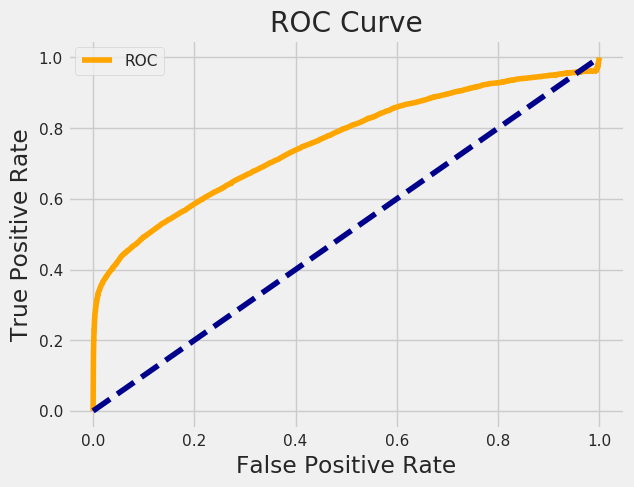

ROC value of:75.70
Accuracy:99.71
F1 score:20.27
Recall:12.96
Precision:46.57

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   3237322
           1       0.47      0.13      0.20      9230

    accuracy                           1.00   3246552
   macro avg       0.73      0.56      0.60   3246552
weighted avg       1.00      1.00      1.00   3246552



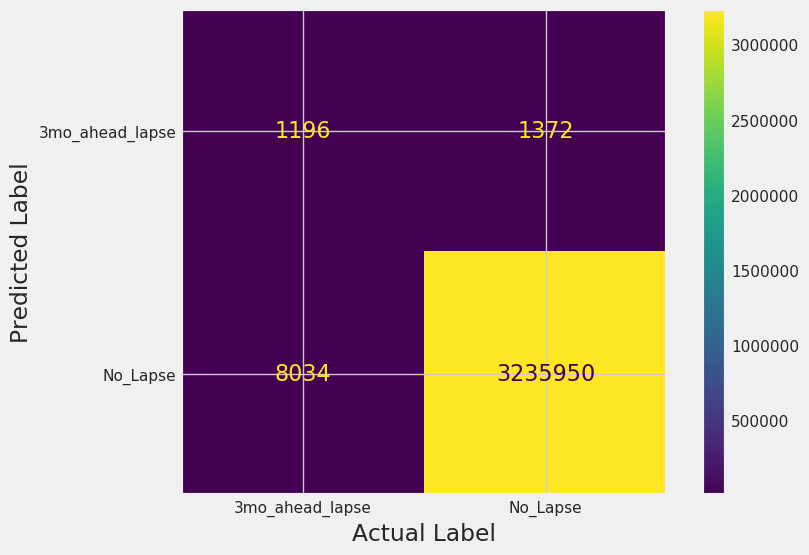

In [30]:
#### In-sample metrics
pred_Y_in = clf.predict(train_X)
pred_Y_prob_in = clf.predict_proba(train_X)[:,1]
tuned_lgb_prob_in = [train_Y, pred_Y_prob_in]
fn_metrics(train_Y, pred_Y_prob_in, pred_Y_in)

### Out-of-sample Fit

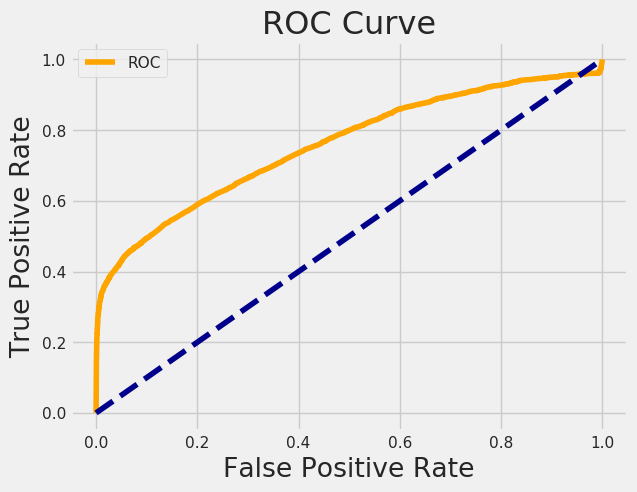

ROC value of:75.73
Accuracy:99.71
F1 score:19.86
Recall:12.63
Precision:46.46

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1618699
           1       0.46      0.13      0.20      4577

    accuracy                           1.00   1623276
   macro avg       0.73      0.56      0.60   1623276
weighted avg       1.00      1.00      1.00   1623276



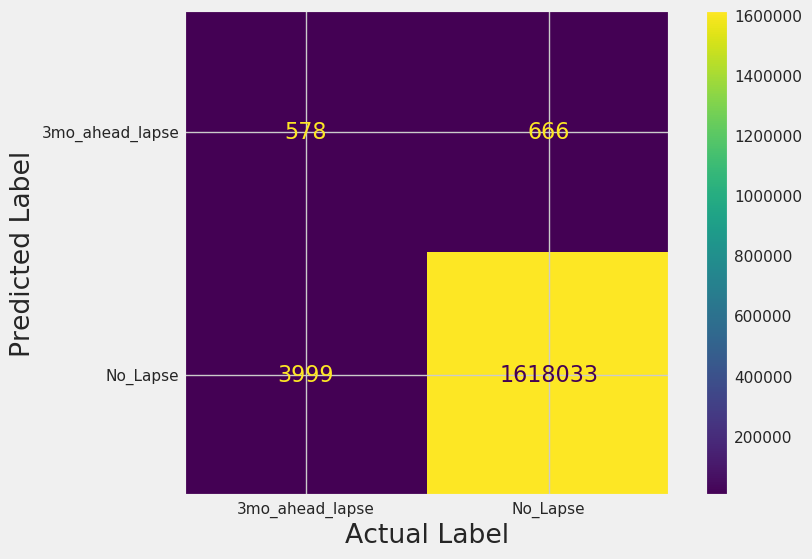

In [31]:
#Out-of-sample metrics 
pred_Y_out = clf.predict(test_X)
pred_Y_prob_out = clf.predict_proba(test_X)[:,1]
tuned_lgb_prob_out = [test_Y, pred_Y_prob_out]

#print out ROC curve, metrics, and confuction matrix
fn_metrics(test_Y, pred_Y_prob_out, pred_Y_out)

In [32]:
%%time
# out-of-sample results 
df_out_predict = pd.DataFrame({'prob': pred_Y_prob_out, 'predict': pred_Y_out}, columns=['prob', 'predict'], index = test_X.index.copy())

CPU times: user 6.62 ms, sys: 0 ns, total: 6.62 ms
Wall time: 6.86 ms


In [33]:
%%time
# input dataset
test_df_processed = test_X.join(df_out_predict, how='right')
test_df_processed.drop(['prob', 'predict'], axis=1, inplace=True)

CPU times: user 857 ms, sys: 864 ms, total: 1.72 s
Wall time: 1.72 s


In [41]:
print(test_df_processed.shape)

(1623276, 71)


In [34]:
del ml_dataset, train_X, train_Y, test_X, test_Y

### Shap Values

In [35]:
%%time
# shap values with light gbm core model
lgbm_shap = clf.predict(test_df_processed, pred_contrib=True)
lgbm_shap_df = pd.DataFrame(lgbm_shap[:, :-1], columns=test_df_processed.columns.tolist(), index = test_df_processed.index.copy())

CPU times: user 40min 58s, sys: 3.63 s, total: 41min 1s
Wall time: 2min 35s


In [36]:
print(lgbm_shap_df.shape)

(1623276, 97)


### export

In [37]:
!pip install awswrangler --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.1 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.24 which is incompatible.


In [38]:
import awswrangler as wr

In [39]:
%%time

# inputs to the model
wr.s3.to_parquet(
    df=df_out_predict,
    path='s3://cdo-ililapse-364524684987-bucket/x266754/lapse/lgbm_df_out_12_22_2022.parquet'
)


CPU times: user 455 ms, sys: 96 ms, total: 551 ms
Wall time: 971 ms


{'paths': ['s3://cdo-ililapse-364524684987-bucket/x266754/lapse/lgbm_df_out_12_22_2022.parquet'],
 'partitions_values': {}}

In [40]:
%%time

# inputs to the model
wr.s3.to_parquet(
    df=test_df_processed,
    path='s3://cdo-ililapse-364524684987-bucket/x266754/lapse/lgbm_input_out_12_22_2022.parquet'
)

del test_df_processed

CPU times: user 14.9 s, sys: 5.79 s, total: 20.7 s
Wall time: 11.2 s


In [41]:
%%time

# shap values
wr.s3.to_parquet(
    df=lgbm_shap_df,
    path='s3://cdo-ililapse-364524684987-bucket/x266754/lapse/shap_values_out_12_22_2022.parquet'
)

del lgbm_shap_df

CPU times: user 46.8 s, sys: 19.9 s, total: 1min 6s
Wall time: 34.5 s


In [43]:
new_df= df [['policy_id', 
         'pfmc_cur_month',
         'val_dt',

         # demographic info
         'holder_age',
         'policy_age',
         'gndr_cd', 
         'mrtl_stat_cd', 
         'prmr_prsnc_chld_ind', 
         'subj_state_cd', 
         'prim_occup_cd',
         'incm_rng_cd',
         'ixi_fin_cohort_cd', 
         'net_wrth_gold_cd',


        #policy info
        'num_policies_hh',
        'prod_grp',
        'issue_year',
        #'policy_age_bucket',
        'base_face_amt',   
        'mod_mpt_total',
        #'cash_val_bucket',
        'accum_actual_prem_paid',
        'mom_accum_prem_paid',
        'rtl_dstrb_orphn_cd',
        'prem_mode',
        'prem_mode_change_flag',

         #SR category
        'SR_TYPE_CATG',
        'sr_create_month',
        'num_sr_catg',
        'max_sr_time',
        'num_sr_6m',
     
        #macro
        'Unemp',
        'ICSA',
        'Dincome',
        'PCE',
        'CPI',
        'Leading',
        'CS_HPI',
        'SP500',
        'ICE_Corp',
        'ICE_HY',
        'FF',
        'T3M',
        'T10Y2Y',
        'Unemp_chg',
        'ICSA_per',
        'Dincome_per',
        'PCE_per',
        'CPI_per',
        'Leading_per',
        'CS_HPI_per',
        'SP500_per',
        'ICE_Corp_chg',
        'ICE_HY_chg',
        'FF_chg',
        'T3M_chg',
        'T10Y2Y_chg',

        '3mo_ahead_Lapse']]


In [44]:
%%time

del df
# score dataset
score = new_df.merge(df_out_predict, how='right', left_index=True, right_index=True)

CPU times: user 15 s, sys: 1.28 s, total: 16.3 s
Wall time: 16.3 s


In [45]:
# output from the model
wr.s3.to_parquet(
    df=score,
    path='s3://cdo-ililapse-364524684987-bucket/x266754/lapse/lgbm_results_out_12_22_2022.parquet'
)

del score

### examples

In [23]:
# df[df['policy_id']=='V1138179'][['policy_id', 'val_dt',  'base_face_amt',
#                                 'mod_mpt_total', 'accum_actual_prem_paid', #'mom_accum_prem_paid', 'prem_mode',
#                                  'current_status', 
#                                  '3mo_ahead_status']]

,policy_id,val_dt,base_face_amt,mod_mpt_total,accum_actual_prem_paid,current_status,3mo_ahead_status
2960216,V1138179,2022-01-31,300000.0,111492.0,60393.1,current,current
2960217,V1138179,2022-02-28,300000.0,108834.0,60657.0,current,current
2960218,V1138179,2022-03-31,300000.0,110684.0,60920.9,current,surrender
